# Data Loading

In [32]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [33]:
train = pd.read_csv('/workspace/Kaggle_Days/CV/cv_comp/train.csv')
test = pd.read_csv('/workspace/Kaggle_Days/CV/cv_comp/test.csv')

def get_train_file_path(image_id):
    return "/workspace/Kaggle_Days/CV/cv_comp/train_images/{}".format(image_id)

def get_test_file_path(image_id):
    return "/workspace/Kaggle_Days/CV/cv_comp/test_images/{}".format(image_id)

train['file_path'] = train['image_id'].apply(get_train_file_path)
test['file_path'] = test['image_id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,image_id,brightness,contrast,colorfulness,sharpness,MOS,file_path
0,00036b9ea9.jpg,0.507058,0.302144,0.170448,21.493220,3.653465,/workspace/Kaggle_Days/CV/cv_comp/train_images...
1,001c4e9be6.jpg,0.618813,0.371019,0.011844,23.570068,3.244275,/workspace/Kaggle_Days/CV/cv_comp/train_images...
2,001c982074.jpg,0.336466,0.243211,0.275342,9.632381,2.843137,/workspace/Kaggle_Days/CV/cv_comp/train_images...
3,001dd41def.jpg,0.371659,0.252384,0.425490,6.649980,2.336364,/workspace/Kaggle_Days/CV/cv_comp/train_images...
4,0024a6e559.jpg,0.545263,0.333793,0.195252,7.552733,2.363636,/workspace/Kaggle_Days/CV/cv_comp/train_images...


,image_id,brightness,contrast,colorfulness,sharpness,file_path
0,00439614c2.jpg,0.387638,0.379885,0.131153,11.679899,/workspace/Kaggle_Days/CV/cv_comp/test_images/...
1,0075aff7fa.jpg,0.665401,0.242671,0.246394,16.625090,/workspace/Kaggle_Days/CV/cv_comp/test_images/...
2,009ed311ee.jpg,0.416759,0.347511,0.165954,18.508671,/workspace/Kaggle_Days/CV/cv_comp/test_images/...
3,00c942fbe7.jpg,0.354192,0.280639,0.219046,21.409334,/workspace/Kaggle_Days/CV/cv_comp/test_images/...
4,011ef38420.jpg,0.458954,0.159165,0.305201,21.264408,/workspace/Kaggle_Days/CV/cv_comp/test_images/...


# Quick EDA

<AxesSubplot:>

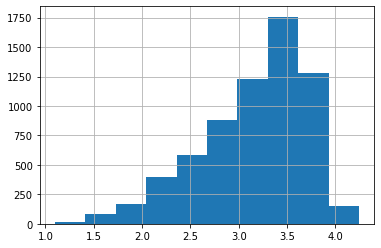

In [34]:
train['MOS'].hist()

In [22]:
# plt.figure(figsize=(20, 20))
# row, col = 5, 5
# for i in range(row * col):
#     plt.subplot(col, row, i+1)
#     image = cv2.imread(train.loc[i, 'file_path'])
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     target = train.loc[i, 'Pawpularity']
#     plt.imshow(image)
#     plt.title(f"target: {target}")
# plt.show()

# Directory settings

In [35]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = '/workspace/data/kaggle_weights'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [36]:
# ====================================================
# CFG
# ====================================================
class CFG:
    num_workers=4
#     size=512
    batch_size=64
    model_name='tf_efficientnet_b3_ns'
    seed=42
    target_size=1
    target_col='MOS'
    n_fold=5

# Library

In [37]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import math
import time
import pickle
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

# Utils

In [39]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [40]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)

Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', "bins"]).size())

fold  bins
0     0         3
      1         7
      2        18
      3        31
      4        60
             ... 
4     8       198
      9       253
      10      274
      11      118
      12       12
Length: 65, dtype: int64

# Dataset

In [41]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

# Transforms

In [47]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.RandomResizedCrop(384, 512, scale=(0.85, 1.0)),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(384, 512),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# MODEL

In [48]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

# Helper functions

In [49]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

In [50]:
# ====================================================
# Helper functions
# ====================================================
def get_features(test_loader, model, device):
    model.eval()
    features = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (images) in tk0:
        images = images.to(device)
        batch_size = images.size(0)
        with torch.no_grad():
            feature = model.feature(images)
        features.append(feature.to('cpu').numpy())
    features = np.concatenate(features)
    return features

In [53]:
IMG_FEATURES = []
test_dataset = TestDataset(train, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, 
                         batch_size=CFG.batch_size * 2, 
                         shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
for fold in range(CFG.n_fold):
    model = CustomModel(CFG, pretrained=False)
    state = torch.load('/workspace/data/kaggle_weights/'+f'{CFG.model_name}_fold{fold}_best.pth', 
                       map_location=torch.device('cpu'))['model']
    model.load_state_dict(state)
    model.to(device)
    features = get_features(test_loader, model, device)
    IMG_FEATURES.append(features)
    del state; gc.collect()
    torch.cuda.empty_cache()

# LGB

In [54]:
# ====================================================
# Model
# ====================================================
def run_single_lightgbm(param, train, features, target, fold=0, categorical=[]):
    
    train[[f"img_{i}" for i in np.arange(1536)]] = IMG_FEATURES[fold]
    
    trn_idx = train[train.fold != fold].index
    val_idx = train[train.fold == fold].index
    LOGGER.info(f'train size : {len(trn_idx)}  valid size : {len(val_idx)}')
    
    if categorical == []:
        trn_data = lgb.Dataset(train.iloc[trn_idx][features].values, label=target.iloc[trn_idx].values)
        val_data = lgb.Dataset(train.iloc[val_idx][features].values, label=target.iloc[val_idx].values)
    else:
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx].values, categorical_feature=categorical)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx].values, categorical_feature=categorical)
        
    num_round = 10000
    clf = lgb.train(param, 
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=10,
                    early_stopping_rounds=10)
    LOGGER.info(f'Dumping model with pickle... lightgbm_fold{fold}.pkl')
    with open(OUTPUT_DIR+f'/lightgbm_fold{fold}.pkl', 'wb') as fout:
        pickle.dump(clf, fout)
    
    oof = np.zeros(len(train))
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    score = get_score(target.iloc[val_idx].values, oof[val_idx])
    LOGGER.info(f"fold{fold} score: {score:<.5f}")
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold

    return oof, fold_importance_df, val_idx


def run_kfold_lightgbm(param, train, features, target, n_fold=5, categorical=[]):
    
    oof = np.zeros(len(train))
    feature_importance_df = pd.DataFrame()
    val_idxes = []
    
    for fold in range(n_fold):
        LOGGER.info(f"===== Fold {fold} =====")
        _oof, fold_importance_df, val_idx = run_single_lightgbm(param, 
                                                                train, features, target, 
                                                                fold=fold, categorical=categorical)
        oof += _oof
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        val_idxes.append(val_idx)
    
    val_idxes = np.concatenate(val_idxes)
    score = get_score(target.iloc[val_idxes].values, oof[val_idxes])
    LOGGER.info(f"CV score: {score:<.5f}")
    
    return oof, feature_importance_df, val_idxes


def show_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
                .groupby("Feature").mean().sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+'feature_importance_df_lightgbm.png')

In [ ]:
target = train['MOS']
features = ['brightness', 'contrast', 'colorfulness', 'sharpness'] + [f"img_{i}" for i in np.arange(1536)]

lgb_param = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'seed': 42,
    'max_depth': -1,
    'min_data_in_leaf': 10,
    'verbosity': -1,
}

oof, feature_importance_df, _ = run_kfold_lightgbm(lgb_param, 
                                                   train, features, target, 
                                                   n_fold=5, categorical=[])

show_feature_importance(feature_importance_df)
feature_importance_df.to_csv(OUTPUT_DIR+f'feature_importance_df.csv', index=False)

===== Fold 0 =====
===== Fold 0 =====
===== Fold 0 =====
train size : 5237  valid size : 1310
train size : 5237  valid size : 1310
train size : 5237  valid size : 1310


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.50036	valid_1's rmse: 0.507241
[20]	training's rmse: 0.456194	valid_1's rmse: 0.46796
[30]	training's rmse: 0.416467	valid_1's rmse: 0.433017
[40]	training's rmse: 0.380744	valid_1's rmse: 0.402098
[50]	training's rmse: 0.348675	valid_1's rmse: 0.374766
[60]	training's rmse: 0.319909	valid_1's rmse: 0.350661
[70]	training's rmse: 0.294105	valid_1's rmse: 0.329508
[80]	training's rmse: 0.271036	valid_1's rmse: 0.311083
[90]	training's rmse: 0.250406	valid_1's rmse: 0.295013
[100]	training's rmse: 0.232011	valid_1's rmse: 0.281046
[110]	training's rmse: 0.215643	valid_1's rmse: 0.269152
[120]	training's rmse: 0.201095	valid_1's rmse: 0.258823
[130]	training's rmse: 0.188176	valid_1's rmse: 0.249994
[140]	training's rmse: 0.176752	valid_1's rmse: 0.242482
[150]	training's rmse: 0.166664	valid_1's rmse: 0.236073
[160]	training's rmse: 0.157758	valid_1's rmse: 0.23063
[170]	training's rmse: 0.1499	valid_1's

Dumping model with pickle... lightgbm_fold0.pkl
Dumping model with pickle... lightgbm_fold0.pkl
Dumping model with pickle... lightgbm_fold0.pkl
fold0 score: 0.19855
fold0 score: 0.19855
fold0 score: 0.19855
===== Fold 1 =====
===== Fold 1 =====
===== Fold 1 =====
train size : 5237  valid size : 1310
train size : 5237  valid size : 1310
train size : 5237  valid size : 1310


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.499598	valid_1's rmse: 0.505796
[20]	training's rmse: 0.454415	valid_1's rmse: 0.466543
[30]	training's rmse: 0.413694	valid_1's rmse: 0.431633
[40]	training's rmse: 0.376995	valid_1's rmse: 0.400697
[50]	training's rmse: 0.343966	valid_1's rmse: 0.373509
[60]	training's rmse: 0.31428	valid_1's rmse: 0.349566
[70]	training's rmse: 0.287579	valid_1's rmse: 0.328601
[80]	training's rmse: 0.263616	valid_1's rmse: 0.310301
[90]	training's rmse: 0.242143	valid_1's rmse: 0.294337
[100]	training's rmse: 0.222923	valid_1's rmse: 0.280556
[110]	training's rmse: 0.205764	valid_1's rmse: 0.268758
[120]	training's rmse: 0.190458	valid_1's rmse: 0.258561
[130]	training's rmse: 0.176841	valid_1's rmse: 0.249842
[140]	training's rmse: 0.164763	valid_1's rmse: 0.242446
[150]	training's rmse: 0.154052	valid_1's rmse: 0.236118
[160]	training's rmse: 0.144585	valid_1's rmse: 0.230699
[170]	training's rmse: 0.136241	valid

Dumping model with pickle... lightgbm_fold1.pkl
Dumping model with pickle... lightgbm_fold1.pkl
Dumping model with pickle... lightgbm_fold1.pkl
fold1 score: 0.20055
fold1 score: 0.20055
fold1 score: 0.20055
===== Fold 2 =====
===== Fold 2 =====
===== Fold 2 =====
train size : 5238  valid size : 1309
train size : 5238  valid size : 1309
train size : 5238  valid size : 1309


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.500107	valid_1's rmse: 0.505279
[20]	training's rmse: 0.455068	valid_1's rmse: 0.466565
[30]	training's rmse: 0.414477	valid_1's rmse: 0.432203
[40]	training's rmse: 0.377896	valid_1's rmse: 0.401728
[50]	training's rmse: 0.344967	valid_1's rmse: 0.374944
[60]	training's rmse: 0.315357	valid_1's rmse: 0.351517
[70]	training's rmse: 0.288757	valid_1's rmse: 0.330989
[80]	training's rmse: 0.264882	valid_1's rmse: 0.313058
[90]	training's rmse: 0.24348	valid_1's rmse: 0.297635
[100]	training's rmse: 0.224327	valid_1's rmse: 0.284312
[110]	training's rmse: 0.207207	valid_1's rmse: 0.272771
[120]	training's rmse: 0.191934	valid_1's rmse: 0.262958
[130]	training's rmse: 0.178327	valid_1's rmse: 0.254508
[140]	training's rmse: 0.166231	valid_1's rmse: 0.247291
[150]	training's rmse: 0.155518	valid_1's rmse: 0.241133
[160]	training's rmse: 0.146021	valid_1's rmse: 0.236016
[170]	training's rmse: 0.137657	valid

Dumping model with pickle... lightgbm_fold2.pkl
Dumping model with pickle... lightgbm_fold2.pkl
Dumping model with pickle... lightgbm_fold2.pkl


[560]	training's rmse: 0.0645983	valid_1's rmse: 0.207016
Early stopping, best iteration is:
[555]	training's rmse: 0.0648803	valid_1's rmse: 0.207004


fold2 score: 0.20700
fold2 score: 0.20700
fold2 score: 0.20700
===== Fold 3 =====
===== Fold 3 =====
===== Fold 3 =====
train size : 5238  valid size : 1309
train size : 5238  valid size : 1309
train size : 5238  valid size : 1309


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.499943	valid_1's rmse: 0.505551
[20]	training's rmse: 0.454868	valid_1's rmse: 0.466693
[30]	training's rmse: 0.414224	valid_1's rmse: 0.432099
[40]	training's rmse: 0.37762	valid_1's rmse: 0.401503
[50]	training's rmse: 0.344662	valid_1's rmse: 0.374481
[60]	training's rmse: 0.315021	valid_1's rmse: 0.35074
[70]	training's rmse: 0.288401	valid_1's rmse: 0.329955
[80]	training's rmse: 0.2645	valid_1's rmse: 0.311822
[90]	training's rmse: 0.243096	valid_1's rmse: 0.296098
[100]	training's rmse: 0.223944	valid_1's rmse: 0.282451
[110]	training's rmse: 0.206835	valid_1's rmse: 0.270724
[120]	training's rmse: 0.191587	valid_1's rmse: 0.260587
[130]	training's rmse: 0.178029	valid_1's rmse: 0.251899
[140]	training's rmse: 0.165986	valid_1's rmse: 0.244524
[150]	training's rmse: 0.155319	valid_1's rmse: 0.238265
[160]	training's rmse: 0.145881	valid_1's rmse: 0.232904
[170]	training's rmse: 0.137551	valid_1'

Dumping model with pickle... lightgbm_fold3.pkl
Dumping model with pickle... lightgbm_fold3.pkl
Dumping model with pickle... lightgbm_fold3.pkl


Early stopping, best iteration is:
[566]	training's rmse: 0.0655816	valid_1's rmse: 0.201551


fold3 score: 0.20155
fold3 score: 0.20155
fold3 score: 0.20155
===== Fold 4 =====
===== Fold 4 =====
===== Fold 4 =====
train size : 5238  valid size : 1309
train size : 5238  valid size : 1309
train size : 5238  valid size : 1309


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.499859	valid_1's rmse: 0.506573
[20]	training's rmse: 0.454765	valid_1's rmse: 0.468335
[30]	training's rmse: 0.414126	valid_1's rmse: 0.434227
[40]	training's rmse: 0.377488	valid_1's rmse: 0.404022
[50]	training's rmse: 0.344515	valid_1's rmse: 0.377347
[60]	training's rmse: 0.314872	valid_1's rmse: 0.353834
[70]	training's rmse: 0.288212	valid_1's rmse: 0.33321
[80]	training's rmse: 0.264293	valid_1's rmse: 0.315194
[90]	training's rmse: 0.242863	valid_1's rmse: 0.299577
[100]	training's rmse: 0.223685	valid_1's rmse: 0.285898
[110]	training's rmse: 0.20654	valid_1's rmse: 0.274068
[120]	training's rmse: 0.191233	valid_1's rmse: 0.263895
[130]	training's rmse: 0.177609	valid_1's rmse: 0.255088
[140]	training's rmse: 0.165503	valid_1's rmse: 0.247554
[150]	training's rmse: 0.154756	valid_1's rmse: 0.241065
[160]	training's rmse: 0.145265	valid_1's rmse: 0.235595
[170]	training's rmse: 0.136886	valid_

In [60]:
train['pred'] = oof
score = get_score(train['MOS'].values, train['pred'].values)
LOGGER.info(f"CV: {score:<.5f}")
train[['image_id', 'MOS', 'pred']].to_pickle(OUTPUT_DIR+'oof.pkl')

CV: 0.20192
CV: 0.20192
CV: 0.20192
